In [1]:
import os
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import scipy 

import seaborn as sns
from IPython.display import Markdown as md

In [15]:
os.chdir('/Users/chenxizhou/Dropbox/code_package/IFlogdensity')
true_data = np.load('data/geyser.npy').astype(np.float64)
df = copy.deepcopy(true_data[:, 0]).reshape(-1, 1)

# original data with 108.0 removed 
data_waiting = df[df != 108.0]

contam_data_list = np.arange(5., 305., 5).reshape(-1, 1)
grid_points = np.arange(1., 311.)
bw_list = [5., 7., 9.]
log_pen_param_list = [-8., -10., -12.]

kernel_type = 'gaussian_poly2'
contam_weight = 1e-3
plot_domain = (1., 310.)
plot_pts_cnt = 3000
seed_num = 1

In [17]:
output_pd = pd.DataFrame()

for bw in bw_list: 
    
    for log_pen_param in log_pen_param_list: 
        
        sup_norm = {}
        
        sup_norm['bw'] = [bw] * len(contam_data_list)
        sup_norm['loglambda'] = [log_pen_param] * len(contam_data_list)
        sup_norm['contam_data'] = contam_data_list.flatten()
        sup_norm['IFsupnorm_ML'] = []
        sup_norm['IFsupnorm_SM'] = []
        
        save_dir_ml = (f'data/PenML-GD-basisn={len(grid_points)}-bw={bw}-' + 
                       f'kernel={kernel_type}-log_pen_param={log_pen_param}-contamweight={contam_weight}-' + 
                       f'plotdomain={plot_domain}-plotcnts={plot_pts_cnt}-seed={seed_num}')
        
        save_dir_sm = (f'data/PenSM-bw={bw}-kernel={kernel_type}-loglambda={log_pen_param}-' + 
                       f'contamweight={contam_weight}-plotdomain={plot_domain}-plotcnts={plot_pts_cnt}')
        
        for contam_data in contam_data_list: 
            
            sub_df_ml = np.load(save_dir_ml + f'/contam_data={contam_data.item()}-IF-newdata.npy')
            sup_norm['IFsupnorm_ML'].append(np.max(np.abs(sub_df_ml)))
            
            sub_df_sm = np.load(save_dir_sm + f'/contam_data={contam_data}-IF-logden-newdata.npy')
            sup_norm['IFsupnorm_SM'].append(np.max(np.abs(sub_df_sm)))
                
        output_pd = pd.concat([output_pd, pd.DataFrame(sup_norm)])

output_pd

,bw,loglambda,contam_data,IFsupnorm_ML,IFsupnorm_SM
0,5.0,-8.0,5.0,83.314486,1455.663777
1,5.0,-8.0,10.0,89.152171,678.326538
2,5.0,-8.0,15.0,89.336812,423.165266
3,5.0,-8.0,20.0,89.062722,299.744637
4,5.0,-8.0,25.0,87.785099,229.699150
...,...,...,...,...,...
55,9.0,-12.0,280.0,161.085269,2207.669727
56,9.0,-12.0,285.0,161.081562,2209.876736
57,9.0,-12.0,290.0,161.012968,2212.076222
58,9.0,-12.0,295.0,160.261972,2214.104698


In [20]:
output_pd.to_csv(f'data/fixLambda-varyContamdata-IFsupnorm-' + 
                 f'contamweight={contam_weight}-plotdomain={plot_domain}-plotcnts={plot_pts_cnt}.csv')

In [26]:
# output_pd[(output_pd.loglambda == -12.) & (output_pd.loglambda == 5.)]
output_pd[output_pd.loglambda == 5.]

,bw,loglambda,contam_data,IFsupnorm_ML,IFsupnorm_SM


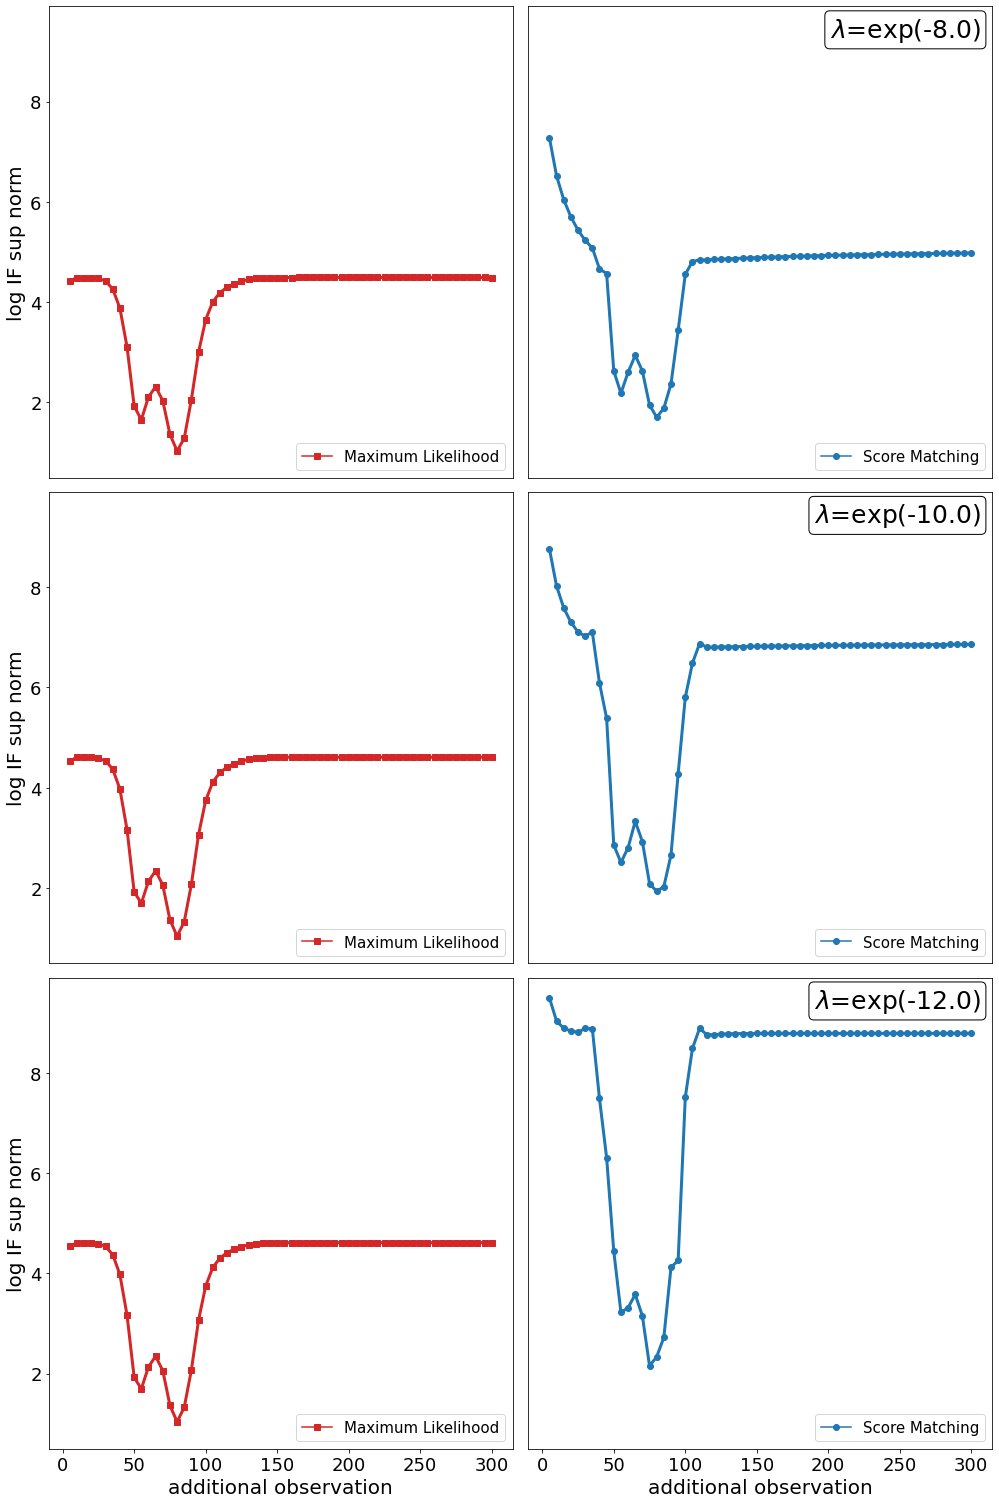

In [43]:
fig = plt.figure(constrained_layout=False)
fig.set_figheight(21)
fig.set_figwidth(14)
ncols = 2
nrows = 3

bw = 5.

label_fontsize = 20
info_fontsize = 25
tick_fontsize = 18
legend_fontsize = 15
linewidth = 3.0
x_label = 'additional observation'
y_label = 'log IF sup norm'
ylimit = (0.5, 9.9)

spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)

for i in range(nrows): 
        
    ax = fig.add_subplot(spec[i, 0])
    log_pen_param = log_pen_param_list[i]
    
    subdf = output_pd[(output_pd.loglambda == log_pen_param) & (output_pd.bw == bw)]
    
    ax.plot(subdf.contam_data, np.log(subdf.IFsupnorm_ML), 
            color = 'tab:red', linestyle = 'solid', linewidth = linewidth)
    ax.plot(subdf.contam_data, np.log(subdf.IFsupnorm_ML), 
            color = 'tab:red', marker = 's', label = 'Maximum Likelihood')
    ax.legend(loc = 'lower right', fontsize = legend_fontsize)
    plt.ylim(ylimit)
    ax.set_ylabel(y_label, fontsize = label_fontsize)

    if i == nrows - 1: 
        ax.set_xlabel(x_label, fontsize = label_fontsize)
    else: 
        ax.set_xticks([])
        
    ax.tick_params(axis = 'both', labelsize = tick_fontsize)
    
    
    ax = fig.add_subplot(spec[i, 1])
    ax.plot(subdf.contam_data, np.log(subdf.IFsupnorm_SM), 
            color = 'tab:blue', linestyle = 'solid', linewidth = linewidth)
    ax.plot(subdf.contam_data, np.log(subdf.IFsupnorm_SM), 
            color = 'tab:blue', marker = 'o', label = 'Score Matching')    
    
    plt.legend(loc = 'lower right', fontsize = legend_fontsize)
    plt.ylim(ylimit)
    ax.set_yticks([])

    if i == nrows - 1: 
        ax.set_xlabel(x_label, fontsize = label_fontsize)
    else: 
        ax.set_xticks([])
    
    ax.tick_params(axis = 'both', labelsize = tick_fontsize)

    info = r"$\lambda$=exp({logpen})".format(logpen = log_pen_param)
    ax.text(0.975, 0.98,
            info,
            fontsize = info_fontsize,
            multialignment = 'left',
            horizontalalignment = 'right',
            verticalalignment = 'top',
            transform = ax.transAxes,
            bbox = {'facecolor': 'none',
                    'boxstyle': 'Round, pad=0.2'})

plt.tight_layout()
plt.savefig(f'plots/PenSM-PenML-geyser-waiting-logdensity-IF-supnorm-contaminateddata-bw={bw}.pdf')

In [ ]:
# contam_data_plot_array = [20., 40., 60., 80., 
#                           100., 200., 300., 400.]
contam_data = 400.

# output_pd = pd.read_csv(f'data/fixContamdata-varyLambda-sup-norm.csv')
fig = plt.figure(constrained_layout=False)
fig.set_figheight(7)
fig.set_figwidth(21)
ncols = 3
nrows = 1

label_fontsize = 20
info_fontsize = 25
tick_fontsize = 18
linewidth = 3.0
x_label = 'log penalty parameter'
y_label = 'IF sup norm'

spec = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)

for i in range(nrows): 
    for j in range(ncols): 
        
        ax = fig.add_subplot(spec[i, j])
        bw = bw_list[j]
        
        subdf = output_pd[(output_pd.bw == bw) & (output_pd.contam_data == contam_data)]
        
        # print(subdf)
        ax.plot(subdf.loglambda, subdf.IFsupnorm_ML, 
                color = 'tab:red', linestyle = 'solid', linewidth = linewidth, label = 'ML')
        ax.plot(subdf.loglambda, subdf.IFsupnorm_SM, 
                color = 'tab:blue', linestyle = 'solid', linewidth = linewidth, label = 'SM')
        
        if i == nrows - 1: 
            ax.set_xlabel(x_label, fontsize = label_fontsize)
            ax.set_xticks(np.arange(-13., 1., 2.))
        else: 
            ax.set_xticks([])
        if j == 0: 
            ax.set_ylabel(y_label, fontsize = label_fontsize)
        # else: 
        #     ax.set_yticks([])
            
        ax.set_ylim((-2, 49))
        
        ax.tick_params(axis = 'both', labelsize = tick_fontsize)

        info = r"$\sigma$={bw}".format(bw = bw_list[j])
        ax.text(0.975, 0.98,
                info,
                fontsize = info_fontsize,
                multialignment = 'left',
                horizontalalignment = 'right',
                verticalalignment = 'top',
                transform = ax.transAxes,
                bbox = {'facecolor': 'none',
                        'boxstyle': 'Round, pad=0.2'})

plt.tight_layout()
# plt.savefig(f'plots/PenSM-PenML-geyser-waiting-logdensity-IF-supnorm-contamweight={0.01}-contam_data={contam_data}.pdf')
plt.savefig(f'plots/PenSM-PenML-geyser-waiting-logdensity-IF-supnorm-contamweight={0.01}-contam_data={contam_data}-zoomin.pdf')